<span style="color:green">
<h2><b>Модель надежности заемщика</b></h2>
</span>

<span style="color:green">
В файле `revo_ds_test_task.csv` собраны данные по повторным займам текущих клиентов компании.<br>
По имеющемуся набору данных, необходимо построить модель, которая будет прогнозировать значение целевой переменной 'bad_flag'.
</span>

<span style="color:green">
Импортируем необходимые для работы модули
</span>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.linear_model import LogisticRegressionCV, LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, average_precision_score, f1_score, precision_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample, shuffle

<span style="color:green">
Считаем таблицу, посмотрим, какие у нее есть столбцы, и каково их наполнение
</span>

In [2]:
data = pd.read_csv('revo_ds_test_task.csv')

In [3]:
data.columns

Index(['loanKey', 'rep_loan_date', 'first_loan', 'dpd_5_cnt', 'dpd_15_cnt',
       'dpd_30_cnt', 'first_overdue_date', 'close_loans_cnt',
       'federal_district_nm', 'TraderKey', 'payment_type_0', 'payment_type_1',
       'payment_type_2', 'payment_type_3', 'payment_type_4', 'payment_type_5',
       'past_billings_cnt', 'score_1', 'score_2', 'age', 'gender', 'bad_flag'],
      dtype='object')

In [4]:
data.head(10)

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaN,3.0,region_6,6,...,10,0,0,0,10.0,NaN,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,...,6,0,0,0,5.0,NaN,NaN,20.0,False,0
2,779736,2016-10-30,2015-12-21,NaN,NaN,NaN,NaN,2.0,region_1,6,...,0,5,0,0,5.0,NaN,NaN,19.0,False,0
3,556376,2016-06-29,2015-06-30,NaN,NaN,NaN,NaN,1.0,region_6,14,...,4,0,0,0,6.0,NaN,NaN,21.0,False,0
4,266968,2015-12-01,2015-08-03,NaN,NaN,NaN,NaN,0.0,region_5,22,...,0,0,0,0,3.0,NaN,NaN,33.0,False,0
5,697186,2016-10-01,2015-08-30,NaN,NaN,NaN,NaN,2.0,region_3,38,...,6,0,0,0,5.0,NaN,NaN,34.0,False,0
6,347907,2016-02-18,2015-06-07,1.0,0.0,0.0,2015-11-06,2.0,region_3,6,...,9,0,0,0,8.0,NaN,NaN,32.0,False,0
7,256097,2015-11-23,2015-06-04,1.0,1.0,0.0,2015-11-06,0.0,region_3,6,...,5,0,0,0,5.0,NaN,NaN,23.0,False,1
8,670540,2016-09-19,2015-12-03,3.0,1.0,0.0,2016-01-15,1.0,region_2,6,...,4,0,0,0,6.0,NaN,NaN,33.0,False,0
9,254453,2015-11-22,2015-06-04,1.0,1.0,0.0,2015-11-06,0.0,region_3,6,...,5,0,0,0,5.0,NaN,NaN,23.0,False,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loanKey              4157 non-null   int64  
 1   rep_loan_date        4157 non-null   object 
 2   first_loan           4157 non-null   object 
 3   dpd_5_cnt            675 non-null    float64
 4   dpd_15_cnt           675 non-null    float64
 5   dpd_30_cnt           675 non-null    float64
 6   first_overdue_date   675 non-null    object 
 7   close_loans_cnt      4142 non-null   float64
 8   federal_district_nm  4146 non-null   object 
 9   TraderKey            4157 non-null   int64  
 10  payment_type_0       4157 non-null   int64  
 11  payment_type_1       4157 non-null   int64  
 12  payment_type_2       4157 non-null   int64  
 13  payment_type_3       4157 non-null   int64  
 14  payment_type_4       4157 non-null   int64  
 15  payment_type_5       4157 non-null   i

<span style="color:green">
Прежде всего косметические замечания:<br>
1. столбцы 'loanKey', 'TraderKey' привести к snake case<br>
2. Всего у нас 4157 записей. Тем не менее:<br>
      - у столбцов 'dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt' ,'first_overdue_date' всего по 675 записей (!!!)<br>
      - у столбца 'close_loans_cnt' 4142 записи<br>
      - у столбца 'federal_district_nm' 4146 запись (и она object типа)<br>
      - у столбца 'past_billings_cnt' 3909 запись<br>
      - у столбца 'score_1' 3507 записей<br>
      - у столбца 'score_2' 239 записи (!!!)<br>
</span>

<span style="color:green">
Переименум столбцы
</span>

In [6]:
columns = {'loanKey': 'loan_key', 'TraderKey': 'trader_key'}
data = data.rename(columns=columns)

<span style="color:green">
'loan_key' - видимо ключ БД, описывающий отдельный займ unique values = 4157<br>
'trader_key' - ??? unique values = 23<br>
'first_loan' - дата первого займа<br>
'rep_loan_date' - дата окончания займа?<br>
'first_overdue_date' - дата первой просрочки по платежу?<br>
'dpd_5/15/30_cnt' - кол-во просрочек в период 5/15/30 дней?<br>
'close_loans_cnt' - количество закрытых кредитов<br>
'federal_district_nm' - номер региона где был займ - перевести в число<br>
'payment_type_0/1/2/3/4/5' - какой-то тип платежа по кредиту<br>
'past_billings_cnt' - количество прошлых счетов<br>
'score_1/2' - ???<br>
'age' - возраст заемщика<br>
'gender' - пол заемщика<br>
'bad_flag' - плохой или нет заемщик<br>
</span>

<span style="color:green">
Сделаем корректные типы данных в столбцах
</span>

In [7]:
data['rep_loan_date'] = pd.to_datetime(data['rep_loan_date'])
data['first_loan'] = pd.to_datetime(data['first_loan'])
data['first_overdue_date'] = pd.to_datetime(data['first_overdue_date'])
data['dpd_5_cnt'] = data['dpd_5_cnt'].astype('Int64')
data['dpd_15_cnt'] = data['dpd_15_cnt'].astype('Int64')
data['dpd_30_cnt'] = data['dpd_30_cnt'].astype('Int64')
data['close_loans_cnt'] = data['close_loans_cnt'].astype('Int64')
data['past_billings_cnt'] = data['past_billings_cnt'].astype('Int64')
data['age'] = data['age'].astype('Int64')
data['gender'] = data['gender'].astype('int')

region_dict = {'region_0': 0, 'region_1': 1, 'region_2': 2, 'region_3': 3, 'region_4': 4, 'region_5': 5, 'region_6': 6, 'region_7': 7}

def correct_region(value):
    if not pd.isna(value):
        value = region_dict[value]
    return value

data['federal_district_nm'] = data['federal_district_nm'].apply(correct_region)
data['federal_district_nm'] = data['federal_district_nm'].astype('Int64')

<span style="color:green">
Отдельно рассмотрим колонки с пропущенными/отсутствующими/NaN значениями
</span>

In [8]:
columns_1 = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt'] 
columns_2_1 = ['payment_type_0', 'payment_type_1', 'payment_type_2'] 
columns_2_2 = ['payment_type_3', 'payment_type_4', 'payment_type_5']
columns_3 = ['past_billings_cnt', 'score_1', 'score_2', 'age', 'gender']

In [9]:
data[columns_1].describe()

,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt
count,675.000000,675.000000,675.000000,4142.000000
mean,1.444444,0.733333,0.280000,1.184693
std,0.900599,0.764572,0.502339,1.723715
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000
75%,2.000000,1.000000,1.000000,2.000000
max,7.000000,5.000000,3.000000,31.000000


In [10]:
data[columns_2_1].describe()

,payment_type_0,payment_type_1,payment_type_2
count,4157.000000,4157.000000,4157.000000
mean,0.018523,0.596103,3.755834
std,0.330359,2.564887,3.810703
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,6.000000
max,15.000000,81.000000,33.000000


In [11]:
data[columns_2_2].describe()

,payment_type_3,payment_type_4,payment_type_5
count,4157.000000,4157.000000,4157.0
mean,0.758239,0.019485,0.0
std,2.212487,0.245960,0.0
min,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.0
max,35.000000,7.000000,0.0


In [12]:
data[columns_3].describe()

,past_billings_cnt,score_1,score_2,age,gender
count,3909.000000,3507.000000,239.000000,4157.000000,4157.000000
mean,4.979023,578.911345,552.546610,34.561222,0.141208
std,3.491556,48.989869,21.492840,10.834143,0.348277
min,1.000000,384.220628,485.874267,18.000000,0.000000
25%,2.000000,547.429791,535.545724,26.000000,0.000000
50%,4.000000,588.531315,556.757944,32.000000,0.000000
75%,6.000000,612.323090,567.608057,41.000000,0.000000
max,21.000000,691.528420,603.311653,74.000000,1.000000


<span style="color:green">
Откровенно левых значений нет, но есть очень высокие показатели 'close_loans_cnt', 'past_billings_cnt'<br>
Колонка 'payment_type_5' определенно не нужна
</span>

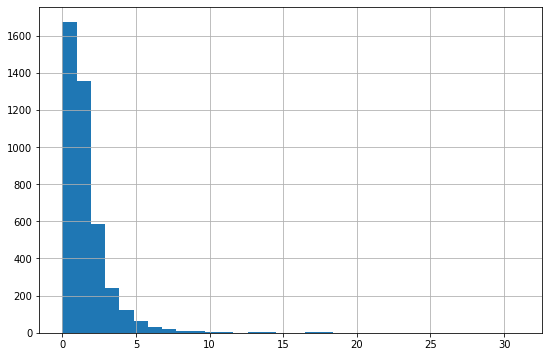

In [13]:
data['close_loans_cnt'].hist(bins=32, figsize=(9,6));
plt.show()

<span style="color:green">
'close_loans_cnt' - рапределение пуассоновское, можно дозаполнить медианным значением
</span>

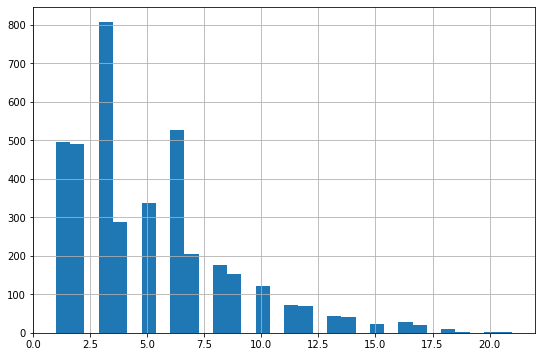

In [14]:
data['past_billings_cnt'].hist(bins=32, figsize=(9,6));
plt.show()

<span style="color:green">
'past_billings_cnt' - рапределение пуассоновское, можно дозаполнить медианным значением
</span>

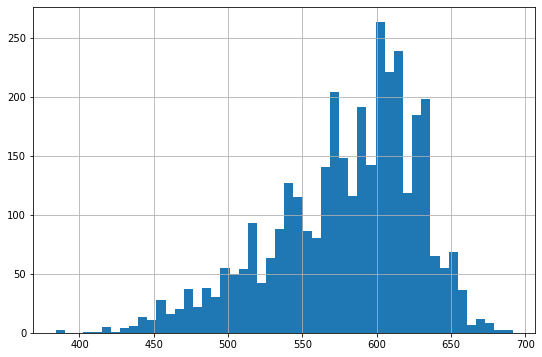

In [15]:
data['score_1'].hist(bins=50, figsize=(9,6))
plt.show()

<span style="color:green">
'score_1' - Похоже на гамма-распределение
</span>

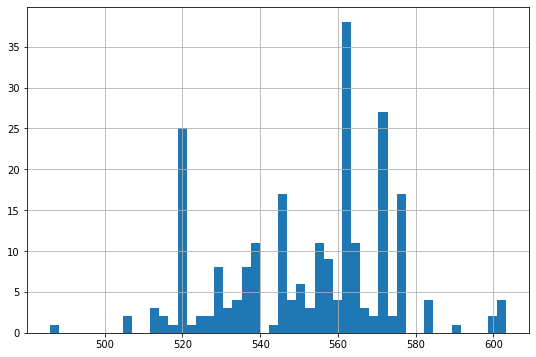

In [16]:
data['score_2'].hist(bins=50, figsize=(9,6))
plt.show()

<span style="color:green">
'score_2' - слишком разреженное множество значений, принимать в рассмотрение не будем
</span>

<span style="color:green">
Заполним отсутсвующие значения в 'close_loans_cnt', 'past_billings_cnt' и 'score_1' 
</span>

In [17]:
median = data['close_loans_cnt'].median()
data['close_loans_cnt'] = data['close_loans_cnt'].fillna(median)

median = data['past_billings_cnt'].median()
data['past_billings_cnt'] = data['past_billings_cnt'].fillna(median)

median = data['score_1'].median()
data['score_1'] = data['score_1'].fillna(median)

<span style="color:green">
Введем колонки 'rep_loan_date'-'first_loan_date' и 'first_overdue_date'-'first_loan_date'<br>
Но сначал проверим, что нет аномальных выбросов по временным промежуткам
</span>

In [18]:
check_1 = data.query('rep_loan_date < first_loan')
check_2 = data.query('first_overdue_date < first_loan')
check_3 = data.query('rep_loan_date < first_overdue_date')
print(check_1)
print(check_2)
print(check_3)

Empty DataFrame
Columns: [loan_key, rep_loan_date, first_loan, dpd_5_cnt, dpd_15_cnt, dpd_30_cnt, first_overdue_date, close_loans_cnt, federal_district_nm, trader_key, payment_type_0, payment_type_1, payment_type_2, payment_type_3, payment_type_4, payment_type_5, past_billings_cnt, score_1, score_2, age, gender, bad_flag]
Index: []

[0 rows x 22 columns]
Empty DataFrame
Columns: [loan_key, rep_loan_date, first_loan, dpd_5_cnt, dpd_15_cnt, dpd_30_cnt, first_overdue_date, close_loans_cnt, federal_district_nm, trader_key, payment_type_0, payment_type_1, payment_type_2, payment_type_3, payment_type_4, payment_type_5, past_billings_cnt, score_1, score_2, age, gender, bad_flag]
Index: []

[0 rows x 22 columns]
Empty DataFrame
Columns: [loan_key, rep_loan_date, first_loan, dpd_5_cnt, dpd_15_cnt, dpd_30_cnt, first_overdue_date, close_loans_cnt, federal_district_nm, trader_key, payment_type_0, payment_type_1, payment_type_2, payment_type_3, payment_type_4, payment_type_5, past_billings_cnt, sco

<span style="color:green">
К счастью, таких аномалий не нашлось, но есть first_overdue_date == NaN
</span>

In [19]:
print(len(data.query('first_loan.isnull()')))
print(len(data.query('first_overdue_date.isnull()'))) # у нас тут 3482 NaN значений
print(len(data.query('first_overdue_date.isnull() & bad_flag == 0'))) # 3197 значений
print(len(data.query('first_overdue_date.notnull() & bad_flag == 0'))) # 543 значений
print(len(data.query('first_overdue_date.isnull() & bad_flag == 1'))) # 285 значений
print(len(data.query('first_overdue_date.notnull() & bad_flag == 1'))) # 132 значений
print(len(data.query('rep_loan_date.isnull()')))

0
3482
3197
543
285
132
0


In [20]:
print(len(data.query('dpd_5_cnt.isnull() & dpd_15_cnt.isnull() & dpd_30_cnt.isnull() & first_overdue_date.isnull()')))

3482


<span style="color:green">
Получается, что dpd_xx_cnt равен NaN, если просрочек не было
</span>

<span style="color:green">
Таким образом, заполним NaN занчения оставшихся столбцов
</span>

In [21]:
def overdue_replace_nan(row):
    if pd.isna(row['first_overdue_date']):
        row['first_overdue_date'] = row['rep_loan_date']
    return row

data = data.apply(overdue_replace_nan, axis=1)

data['credit_dur'] = (data['rep_loan_date'] - data['first_loan']).astype('timedelta64[D]')
data['credit_dur'] = data['credit_dur'].astype('int32')

data['first_overdue_dur'] = (data['first_overdue_date'] - data['first_loan']).astype('timedelta64[D]')
data['first_overdue_dur'] = data['first_overdue_dur'].astype('int32')

data['dpd_5_cnt'] = data['dpd_5_cnt'].fillna(0)
data['dpd_15_cnt'] = data['dpd_15_cnt'].fillna(0)
data['dpd_30_cnt'] = data['dpd_30_cnt'].fillna(0)

<span style="color:green">
Подготовим таблицу для дальнейшего анализа
</span>

In [22]:
working_columns = ['credit_dur', 'first_overdue_dur', 'dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 
                    'close_loans_cnt', 'payment_type_0', 'payment_type_1', 
                    'payment_type_2', 'payment_type_3', 'payment_type_4', 'past_billings_cnt', 
                    'score_1', 'age', 'gender', 'bad_flag']

refine_data = data[working_columns]

<span style="color:green">
Проведем анализ мультиколлинеарности столбцов между собой
</span>

In [23]:
def get_vif(df, spec_features):
    vif, tolerance = {}, {}
    for spf in spec_features:
        X = [x for x in spec_features if x != spf]
        X, y = df[X], df[spf]

        r2 = LinearRegression().fit(X, y).score(X, y)
        tolerance[spf] = 1-r2
        vif[spf] = 1 / (tolerance[spf])

    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

result = get_vif(refine_data, working_columns)
print(result)

                         VIF  Tolerance
credit_dur         13.637892   0.073325
first_overdue_dur  11.113027   0.089984
dpd_5_cnt           3.538737   0.282587
dpd_15_cnt          3.032830   0.329725
dpd_30_cnt          1.726758   0.579120
close_loans_cnt     2.420430   0.413150
payment_type_0      1.017190   0.983101
payment_type_1      1.784810   0.560284
payment_type_2      5.252333   0.190392
payment_type_3      2.254354   0.443586
payment_type_4      1.030301   0.970591
past_billings_cnt   6.773297   0.147639
score_1             1.159742   0.862260
age                 1.070098   0.934494
gender              1.061582   0.941990
bad_flag            1.101650   0.907729


<span style="color:green">
Выберем значения с наибольшим VIF
</span>

In [24]:
look_closely = ['credit_dur', 'first_overdue_dur', 'past_billings_cnt', 'payment_type_2', 'dpd_5_cnt', 'dpd_15_cnt', 'close_loans_cnt']
print(get_vif(refine_data, look_closely))

                         VIF  Tolerance
credit_dur         13.505508   0.074044
first_overdue_dur  11.018556   0.090756
past_billings_cnt   4.924894   0.203050
payment_type_2      2.002002   0.499500
dpd_5_cnt           3.486461   0.286824
dpd_15_cnt          2.263233   0.441846
close_loans_cnt     2.165436   0.461801


In [25]:
# Исключим 'credit_dur'
look_closely = ['first_overdue_dur', 'past_billings_cnt', 'payment_type_2', 'dpd_5_cnt', 'dpd_15_cnt', 'close_loans_cnt']
print(get_vif(refine_data, look_closely))

                        VIF  Tolerance
first_overdue_dur  2.800750   0.357047
past_billings_cnt  4.480779   0.223175
payment_type_2     2.001625   0.499594
dpd_5_cnt          2.533142   0.394767
dpd_15_cnt         2.259540   0.442568
close_loans_cnt    2.159260   0.463122


In [26]:
# Исключим 'first_overdue_dur'
look_closely = ['credit_dur', 'past_billings_cnt', 'payment_type_2', 'dpd_5_cnt', 'dpd_15_cnt', 'close_loans_cnt']
print(get_vif(refine_data, look_closely))

                        VIF  Tolerance
credit_dur         3.432895   0.291299
past_billings_cnt  4.924313   0.203074
payment_type_2     2.000578   0.499855
dpd_5_cnt          2.302407   0.434328
dpd_15_cnt         2.254562   0.443545
close_loans_cnt    2.165418   0.461805


<span style="color:green">
Если удалить 'credit_dur' - то VIF в целом сильнее упадет
</span>

In [27]:
# Исключим 'past_billings_cnt'
look_closely = ['first_overdue_dur', 'payment_type_2', 'dpd_5_cnt', 'dpd_15_cnt', 'close_loans_cnt']
print(get_vif(refine_data, look_closely))

                        VIF  Tolerance
first_overdue_dur  1.916563   0.521767
payment_type_2     1.688040   0.592403
dpd_5_cnt          2.383811   0.419496
dpd_15_cnt         2.258177   0.442835
close_loans_cnt    1.757339   0.569042


In [28]:
# Исключим 'close_loans_cnt'
look_closely = ['first_overdue_dur', 'past_billings_cnt', 'payment_type_2', 'dpd_5_cnt', 'dpd_15_cnt']
print(get_vif(refine_data, look_closely))

                        VIF  Tolerance
first_overdue_dur  2.780075   0.359702
past_billings_cnt  3.646735   0.274218
payment_type_2     1.997920   0.500521
dpd_5_cnt          2.532980   0.394792
dpd_15_cnt         2.255220   0.443416


In [29]:
# Исключим 'dpd_5_cnt'
look_closely = ['first_overdue_dur', 'past_billings_cnt', 'payment_type_2', 'dpd_15_cnt', 'close_loans_cnt']
print(get_vif(refine_data, look_closely))

                        VIF  Tolerance
first_overdue_dur  2.539795   0.393733
past_billings_cnt  4.216634   0.237156
payment_type_2     1.997244   0.500690
dpd_15_cnt         1.210778   0.825915
close_loans_cnt    2.159122   0.463151


In [30]:
# Исключим 'close_loans_cnt'
look_closely = ['dpd_15_cnt', 'past_billings_cnt', 'payment_type_2', 'dpd_5_cnt', 'close_loans_cnt']
print(get_vif(refine_data, look_closely))

                        VIF  Tolerance
dpd_15_cnt         2.253044   0.443844
past_billings_cnt  3.066214   0.326135
payment_type_2     1.989946   0.502526
dpd_5_cnt          2.297121   0.435328
close_loans_cnt    2.143321   0.466566


In [31]:
# Исключим 'payment_type_2'
look_closely = ['first_overdue_dur', 'past_billings_cnt', 'dpd_5_cnt', 'dpd_15_cnt', 'close_loans_cnt']
print(get_vif(refine_data, look_closely))

                        VIF  Tolerance
first_overdue_dur  2.784407   0.359143
past_billings_cnt  3.778797   0.264634
dpd_5_cnt          2.527597   0.395633
dpd_15_cnt         2.259525   0.442571
close_loans_cnt    2.155263   0.463981


<span style="color:green">
В итоге, имеет смысл удалить еще 'past_billings_cnt', 'dpd_5_cnt'<br>
</span>

In [32]:
refine_data = refine_data.drop(['credit_dur', 'past_billings_cnt', 'dpd_5_cnt'], axis=1)

<span style="color:green">
Теперь посмотрим, имеет ли место смещение в значениях колонки 'bad_flag'
</span>

In [33]:
zeros_bad_data = refine_data.query('bad_flag == 0')
ones_bad_data = refine_data.query('bad_flag == 1')

zeros_bad = len(zeros_bad_data)
ones_bad = len(ones_bad_data)

print(f"Количество нулей: {zeros_bad},  количество единиц: {ones_bad}")

Количество нулей: 3740,  количество единиц: 417


<span style="color:green">
Смещение в данных колоссальное. Попробуем выровнять его, "размножив" строки с bad_flag == 1
</span>

In [34]:
ones_upsample = resample(ones_bad_data, n_samples=zeros_bad, replace=True, random_state=123)
refine_data = np.concatenate([zeros_bad_data, ones_upsample])
refine_data = shuffle(refine_data, random_state=123)

In [35]:
refine_data = pd.DataFrame(refine_data, columns=['first_overdue_dur', 'dpd_15_cnt', 'dpd_30_cnt', 
                    'close_loans_cnt', 'payment_type_0', 'payment_type_1', 
                    'payment_type_2', 'payment_type_3', 'payment_type_4', 
                    'score_1', 'age', 'gender', 'bad_flag'])

<span style="color:green">
Выделим часть с признаками и целевым значением
</span>

In [36]:
features = refine_data.drop(['bad_flag'], axis=1)
target = refine_data['bad_flag']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=123)

<span style="color:green">
Далее применим для решения задачи нахождения значения параметра bad_flag следующие методы: LogisticRegression, SGDRegression, Support Vector Cluster и CatBoost
</span>

In [37]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

<span style="color:green">
<b>LOGISTIC REGRESSION</b>
</span>

In [38]:
model_logreg = LogisticRegressionCV(solver='liblinear', random_state=123)
model_logreg.fit(features_train, target_train)

# Используем кросс-валидацию
scores = cross_val_score(model_logreg, features_train, target_train, cv=5, scoring='accuracy')
print(f'Validation ACC scores: {scores}, mean ACC validation score: {np.mean(scores)}')

Validation ACC scores: [0.70342523 0.69924812 0.71512114 0.73433584 0.73411371], mean ACC validation score: 0.7172488076378236


<span style="color:green">
Точность все-таки очень низкая, поэтому будем рассматривать другие регрессионные модели
</span>

<span style="color:green">
Построим ROC_AUC график для линейной регрессии
</span>

AUC value: 0.7753349395178586


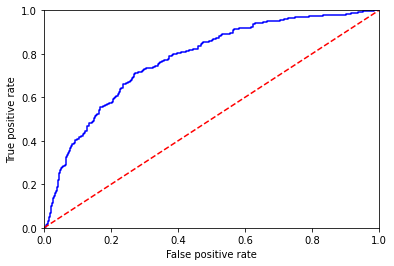

In [39]:
probs = model_logreg.predict_proba(features_test)
preds = probs[:,1]

fpr_logreg, tpr_logreg, threshold = roc_curve(target_test, preds)
auc_value_logreg = auc(fpr_logreg, tpr_logreg)

print(f"AUC value: {auc_value_logreg}")

plt.plot(fpr_logreg, tpr_logreg, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

<span style="color:green">
ROC_AUC график для линейной регрессии также показывает не самую лучшую работу регрессора.
</span>

<span style="color:green">
<b>STOCHASTIC REGRESSION</b>
</span>

In [42]:
model_sgdclass = SGDClassifier(random_state=123, penalty='l1', loss='log_loss')
model_sgdclass.fit(features_train, target_train)

scores = cross_val_score(model_sgdclass, features_train, target_train, cv=5, scoring='accuracy')

print(f'Validation ACC scores: {scores}, mean ACC validation score: {np.mean(scores)}')

Validation ACC scores: [0.68170426 0.68421053 0.71512114 0.7176274  0.69983278], mean ACC validation score: 0.6996992201797694


<span style="color:green">
Построим ROC_AUC график для стохастического классификатора
</span>

AUC value: 0.7663537704824274


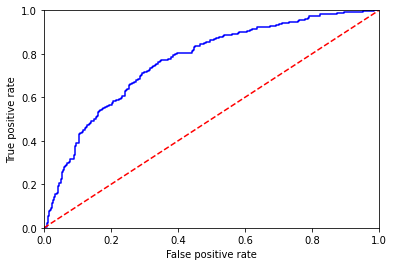

In [43]:
probs = model_sgdclass.predict_proba(features_test)
preds = probs[:,1]

fpr_sgd, tpr_sgd, threshold = roc_curve(target_test, preds)
auc_value_sgd = auc(fpr_sgd, tpr_sgd)

print(f"AUC value: {auc_value_sgd}")

plt.plot(fpr_sgd, tpr_sgd, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

<span style="color:green">
В целом, по значению средней акууратности на кросс-валидации, SGD работет даже хуже обычной линейной регрессии, поэтому в дальнейшем, SGD, тем более, не будет рассматриваться как рабочий алгоритм
</span>

<span style="color:green">
<b>SUPPORT VECTOR CLUSTER</b>
</span>

In [44]:
# Linear kernel
model_scv_linear = SVC(kernel='linear', probability=True)
params_svc_linear = {'tol': np.arange(0.0005,0.002,0.0001), 'C': [0.1, 1]}
grid_search_svc_linear = GridSearchCV(model_scv_linear, params_svc_linear, cv=5, scoring='accuracy')
grid_search_svc_linear.fit(features_train, target_train)

svc_linear_params = grid_search_svc_linear.best_params_
svc_linear_acc = grid_search_svc_linear.best_score_
print(f'SVC linear best params: {svc_linear_params}')
print(f'SVC linear best score: {svc_linear_acc}')

SVC linear best params: {'C': 1, 'tol': 0.0005}
SVC linear best score: 0.711900570825056


<span style="color:green">
Результат SVC кластеризатора с линейным ядром также мало ушел от обычной линейной регрессии, однако построим также и ROC-AUC кривую
</span>

AUC value: 0.774275965855472


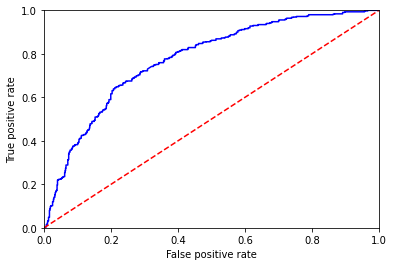

In [45]:
test_svc_mod = SVC(kernel='linear', probability=True, tol=svc_linear_params['tol'], C=svc_linear_params['C'])
test_svc_mod.fit(features_train, target_train)
probs = test_svc_mod.predict_proba(features_test)
preds = probs[:,1]

fpr_sgd, tpr_sgd, threshold = roc_curve(target_test, preds)
auc_value_sgd = auc(fpr_sgd, tpr_sgd)

print(f"AUC value: {auc_value_sgd}")

plt.plot(fpr_sgd, tpr_sgd, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

<span style="color:green">
Теперь попробуем SVC кластеризатор с rbf ядром
</span>

In [46]:
# RBF kernel
model_scv_rbf = SVC(kernel='rbf', probability=True)
params_svc_rbf = {'C': [0.1, 1], 'gamma': np.arange(0.01,0.12,0.01)}
grid_search_svc_rbf = GridSearchCV(model_scv_rbf, params_svc_rbf, cv=5, scoring='accuracy')
grid_search_svc_rbf.fit(features_train, target_train)

svc_rbf_params = grid_search_svc_rbf.best_params_
svc_rbf_acc = grid_search_svc_rbf.best_score_
print(f'SVC rbf best params: {svc_rbf_params}')
print(f'SVC rbf best score: {svc_rbf_acc}')

SVC rbf best params: {'C': 1, 'gamma': 0.11}
SVC rbf best score: 0.7622026079691984


<span style="color:green">
Результат лучше, чем у SVC кластеризатора с линейным ядром, но все равно не слишком хороший<br/>
ROC-AUC график
</span>

AUC value: 0.8322505290400068


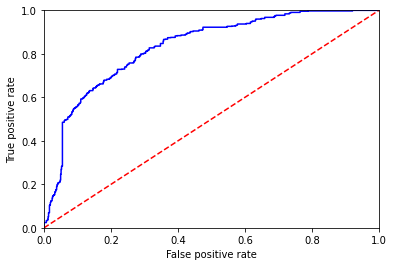

In [47]:
test_svc_mod = SVC(kernel='rbf', probability=True, gamma=svc_rbf_params['gamma'], C=svc_rbf_params['C'])
test_svc_mod.fit(features_train, target_train)
probs = test_svc_mod.predict_proba(features_test)
preds = probs[:,1]

fpr_sgd, tpr_sgd, threshold = roc_curve(target_test, preds)
auc_value_sgd = auc(fpr_sgd, tpr_sgd)

print(f"AUC value: {auc_value_sgd}")

plt.plot(fpr_sgd, tpr_sgd, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

<span style="color:green">
Теперь попробуем SVC кластеризатор с полиномиальным ядром
</span>

In [48]:
# POLY kernel
model_scv_poly = SVC(kernel='poly', probability=True)
params_svc_poly = {'C': [1], 'gamma': np.arange(0.01,0.12,0.01), 'degree': [2,3,4], 'coef0': [0.001, 0.01, 0.1, 1]}
grid_search_svc_poly = GridSearchCV(model_scv_poly, params_svc_poly, cv=5, scoring='accuracy')
grid_search_svc_poly.fit(features_train, target_train)

svc_poly_params = grid_search_svc_poly.best_params_
svc_poly_acc = grid_search_svc_poly.best_score_
print(f'SVC poly best params: {svc_poly_params}')
print(f'SVC poly best score: {svc_poly_acc}')

SVC poly best params: {'C': 1, 'coef0': 1, 'degree': 4, 'gamma': 0.11}
SVC poly best score: 0.7799152284278142


<span style="color:green">
Опять же - результат чуть лучше, чем у предыдущего, но, по большому счету, не очень убедительный в плане прогностической силы
</span>

AUC value: 0.8333943993251165


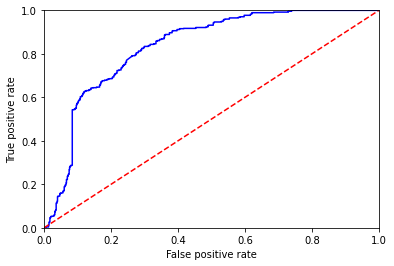

In [49]:
test_svc_mod = SVC(kernel='poly', probability=True, gamma=svc_poly_params['gamma'], C=svc_poly_params['C'], degree=svc_poly_params['degree'], coef0=svc_poly_params['coef0'])
test_svc_mod.fit(features_train, target_train)
probs = test_svc_mod.predict_proba(features_test)
preds = probs[:,1]

fpr_sgd, tpr_sgd, threshold = roc_curve(target_test, preds)
auc_value_sgd = auc(fpr_sgd, tpr_sgd)

print(f"AUC value: {auc_value_sgd}")

plt.plot(fpr_sgd, tpr_sgd, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

<span style="color:green">
<b>LIGHT GBM</b>
</span>

In [50]:
model_lgb = lgb.LGBMClassifier(random_state=123)
params_lgb = {"n_estimators" : range(40,201,10), "max_depth" : range(5,25)}
grid_search_lgb = GridSearchCV(model_lgb, params_lgb, cv=3, scoring='accuracy')
grid_search_lgb.fit(features_train, target_train)

lgb_params = grid_search_lgb.best_params_
lgb_acc = grid_search_lgb.best_score_
print(f'LightGBM best params: {lgb_params}')
print(f'LightGBM best score: {lgb_acc}')

LightGBM best params: {'max_depth': 21, 'n_estimators': 200}
LightGBM best score: 0.9336575306537825


<span style="color:green">
Очень хороший результат. Посмотрим на ROC-AUC график
</span>

AUC value: 0.984725757099145


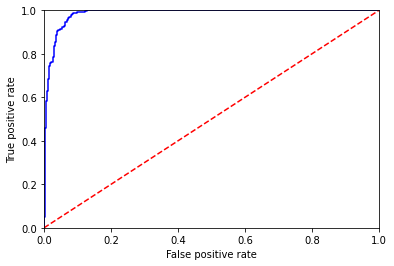

In [51]:
test_lgb_mod = lgb.LGBMClassifier(random_state=123, n_estimators=lgb_params['n_estimators'], max_depth=lgb_params['max_depth'])
test_lgb_mod.fit(features_train, target_train)
probs = test_lgb_mod.predict_proba(features_test)
preds = probs[:,1]

fpr_sgd, tpr_sgd, threshold = roc_curve(target_test, preds)
auc_value_sgd = auc(fpr_sgd, tpr_sgd)

print(f"AUC value: {auc_value_sgd}")

plt.plot(fpr_sgd, tpr_sgd, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

<span style="color:green">
Внешний вид графика подтверждает его способность находить правильные предсказания при малом количестве ложноположительных ответов. Поэтому, модель LightGBM берем, как рабочую.
</span>

<span style="color:green">
Предскажем с помощью нее тестовые значения и построим дополнительные параметры, такие как: аккуратность предсказания, матрицу неточностей и краткую сводку по прочим метрикам предсказания
</span>

In [52]:
target_pred = test_lgb_mod.predict(features_test)
accuracy = accuracy_score(target_test, target_pred)
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(target_test, target_pred)
print(conf_matrix)

class_rep = classification_report(target_test, target_pred)
print(class_rep)

Accuracy: 0.9391711229946524
[[661  87]
 [  4 744]]
              precision    recall  f1-score   support

         0.0       0.99      0.88      0.94       748
         1.0       0.90      0.99      0.94       748

    accuracy                           0.94      1496
   macro avg       0.94      0.94      0.94      1496
weighted avg       0.94      0.94      0.94      1496



<span style="color:green">
Таким образом, в качестве предиктивной модели, выбираем модель LightGBM, которая дает акууратность предсказания 0.94 на тестовых данных
</span>